In [26]:
import warnings

import matplotlib.pyplot as plt
from models.peer import Peer

from models.interactive_parameter import InteractiveUtils
import numpy as np
%config InlineBackend.figure_format = 'retina'

warnings.filterwarnings('ignore')

In [27]:
def clip(
    values: np.ndarray, min_value: float = None, max_value: float = None
) -> np.ndarray:
    return np.clip(values, min_value, max_value)


def equation_multi(X, Y, E, E1, B1, K1, nu1, E2, B2, K2, nu2, *args, **kwargs):
    inner1 = np.power((K1 / X), nu1) - 1
    inner2 = np.power((K2 / Y), nu2) - 1

    part1 = np.power(E1 + B1 * np.log(inner1), 1 / 2)
    part2 = np.power(E2 + B2 * np.log(inner2), 1 / 2)

    part1 = np.nan_to_num(part1, posinf=0)
    part2 = np.nan_to_num(part2, posinf=0)

    output = clip(
        clip(part1, 0) * clip(part2, 0) + E,
        0,
        8.5,
    )

    return output


def sigmoid_output(x, y, E, E1, B1, K1, nu1, E2, B2, K2, nu2, *args, **kwargs):
    x_range = [x]
    y_range = [y]

    X, Y = np.meshgrid(x_range, y_range)
    Z = equation_multi(X, Y, E, E1, B1, K1, nu1, E2, B2, K2, nu2)

    return Z[0][0]

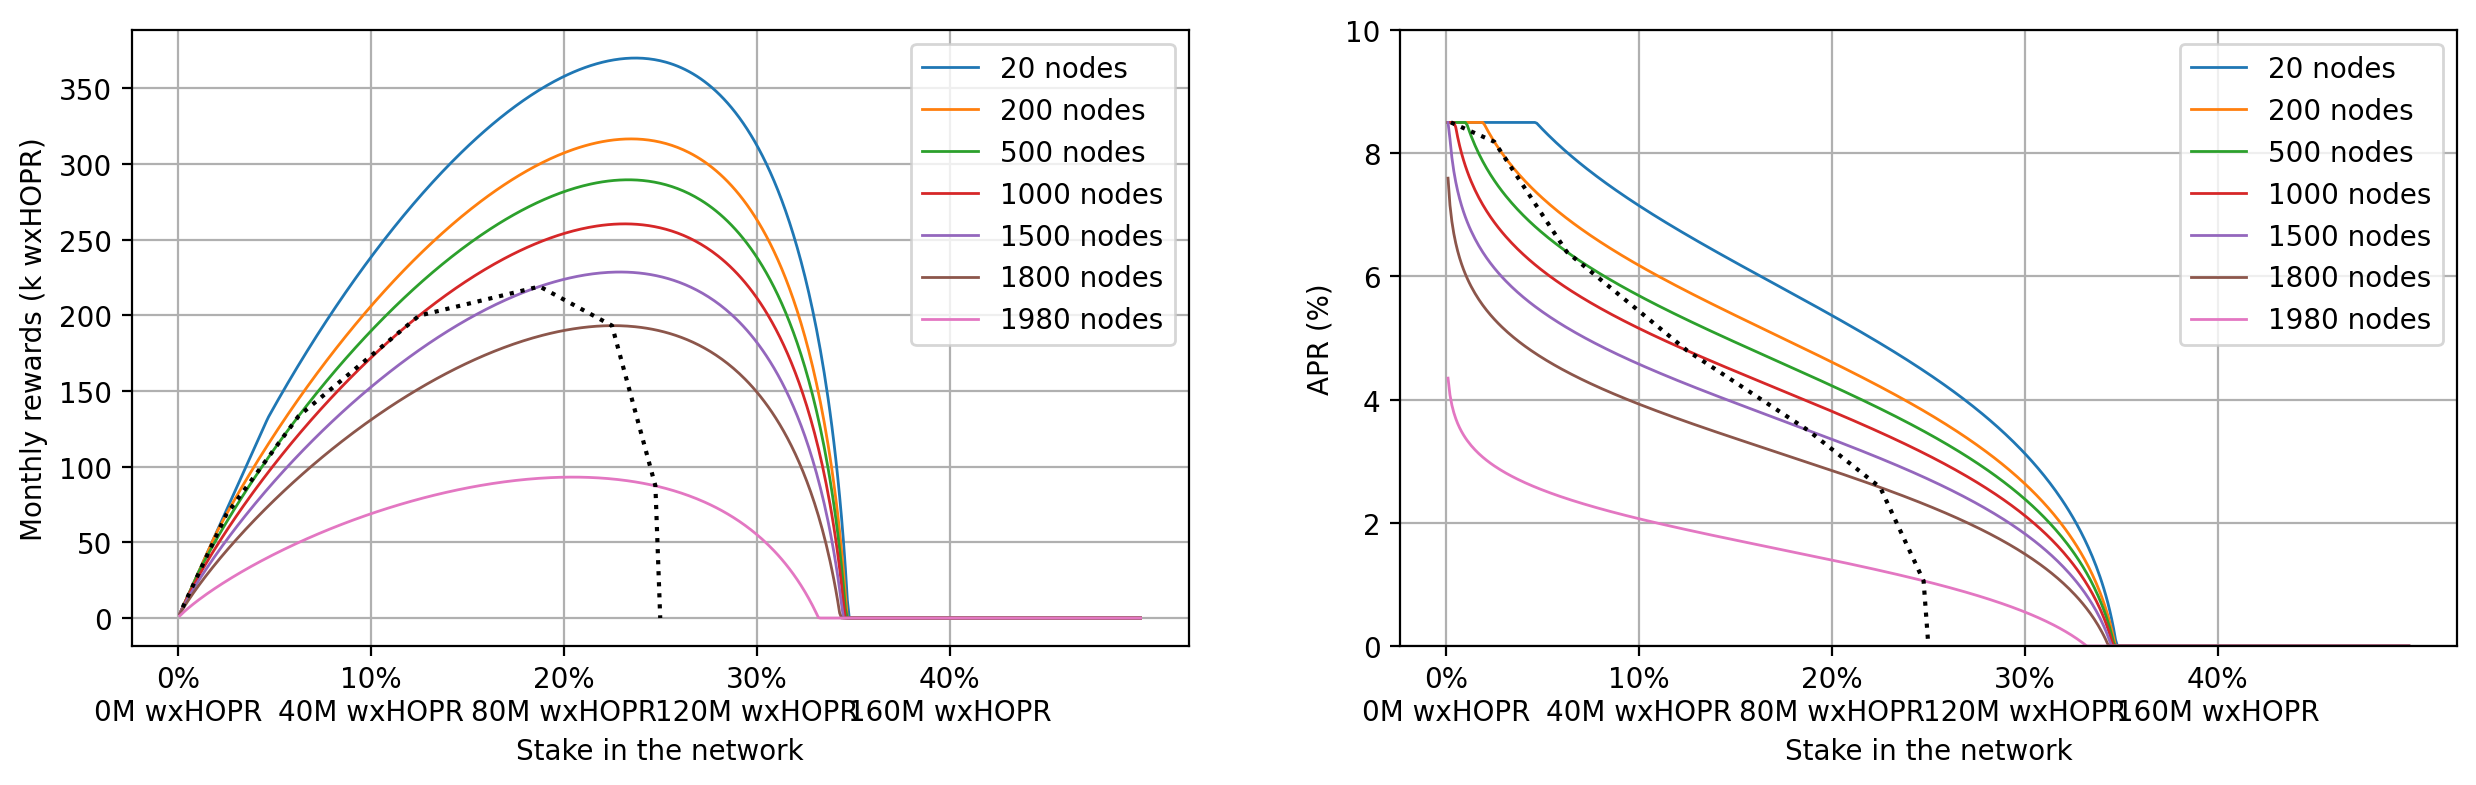

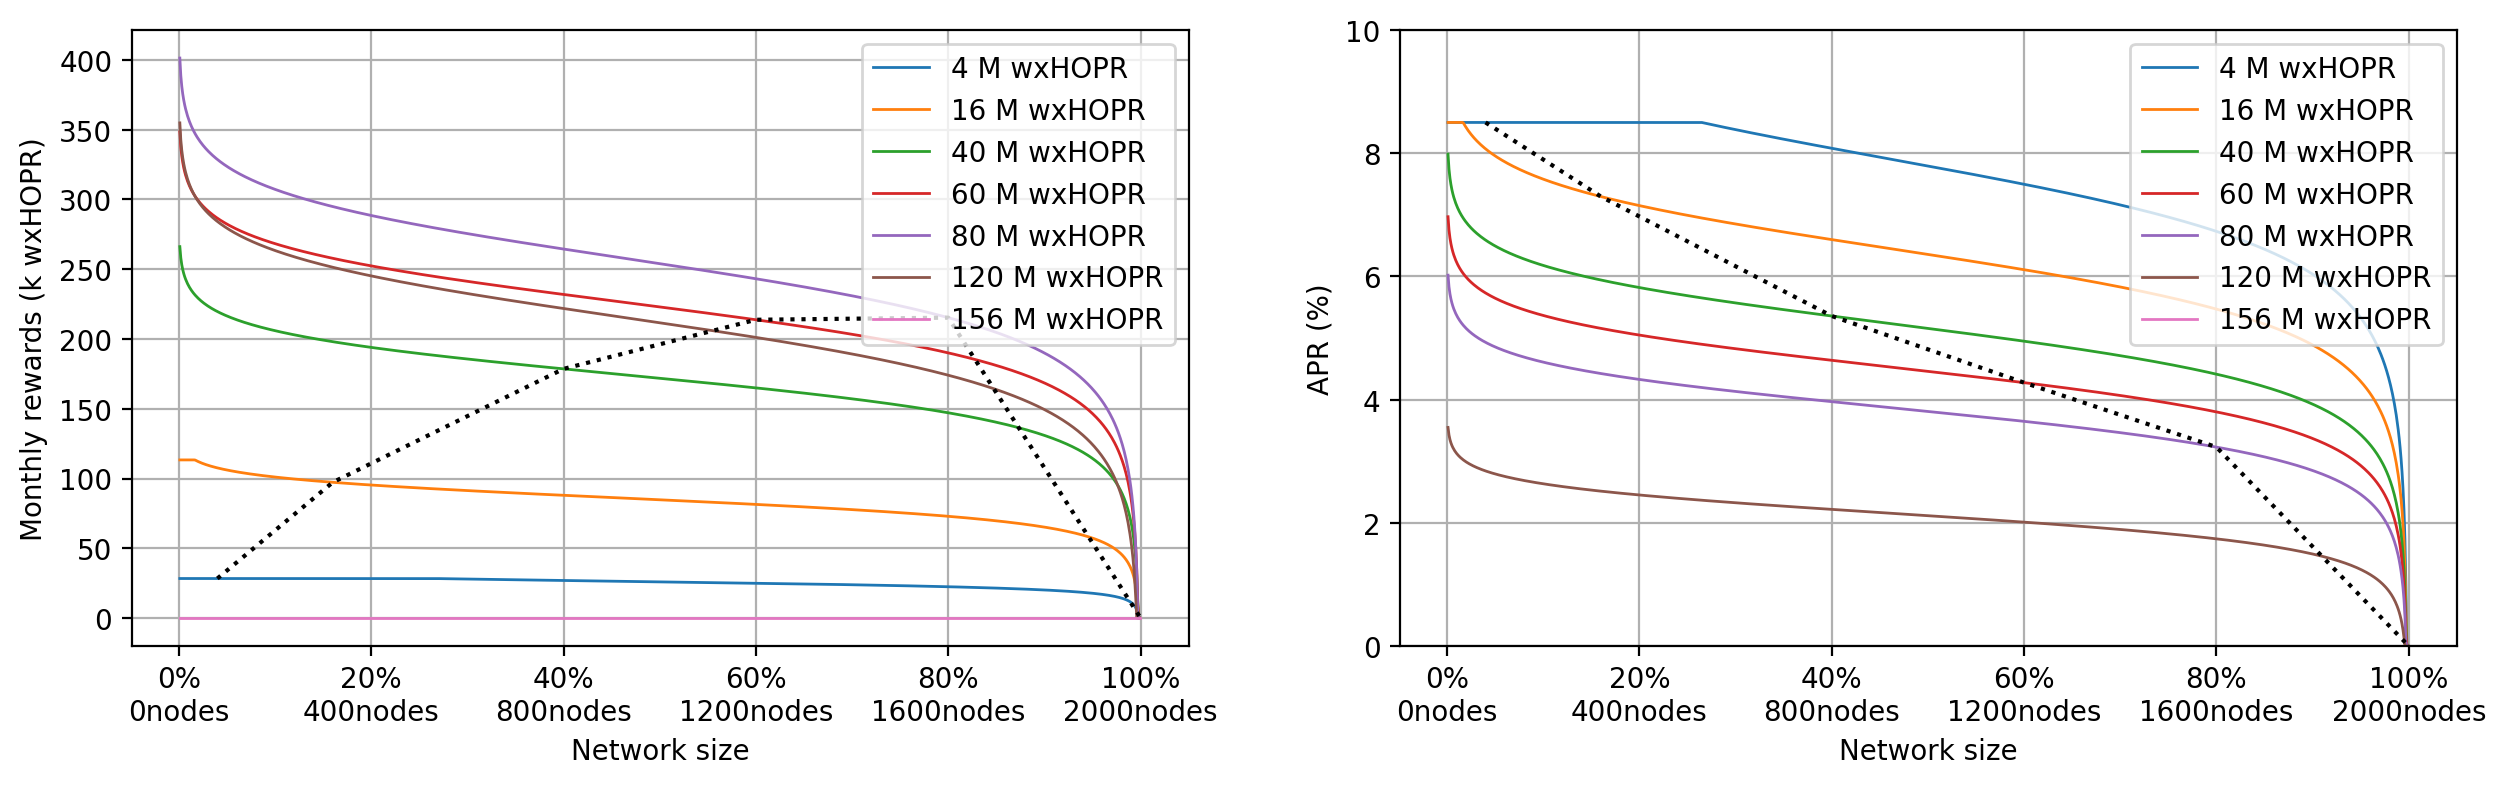

In [74]:
unit = {1e0: "", 1e3: "k", 1e6: "M", 1e9: "B"}
params = InteractiveUtils.loadSimulationConfigFile("assets/sigmoid.config.pow.1.2.yaml")
params_dict = {param.name: param.value for param in params}


def stake_increase(nw_sizes_ratios=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]):
    fig = plt.figure(figsize=(15, 4))
    axes = [fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)]
    range_x = np.arange(0, 0.5, 0.001)[1:]

    for ratio in nw_sizes_ratios:
        grid = np.meshgrid(range_x, np.array([ratio]))

        apr = equation_multi(
            *grid,
            **{param.name: param.value for param in params},
        )

        axes[0].plot(
            range_x,
            apr[0] / 100.0 * (400e6 * range_x) / 12.0 / 1000,
            linewidth=1,
            antialiased=True,
            label=f"{ratio * 2000:.0f} nodes",
        )

        axes[1].plot(
            range_x,
            apr[0],
            linewidth=1,
            antialiased=True,
            label=f"{ratio * 2000:.0f} nodes",
        )

    avg_stake = 50_000
    range_y = np.array(nw_sizes_ratios + [1])
    range_x = range_y * 2000 * avg_stake / 400e6

    grid = np.meshgrid(range_x, range_y)

    apr = equation_multi(
        *grid,
        **{param.name: param.value for param in params},
    )

    axes[0].plot(
        range_x,
        np.diag(apr) / 100.0 * (400e6 * range_x) / 12.0 / 1000,
        ":",
        color="black",
    )
    axes[1].plot(range_x, np.diag(apr), ":", color="black")

    axes[0].set_ylabel("Monthly rewards (k wxHOPR)")
    axes[1].set_ylabel("APR (%)")
    axes[1].set_ylim(0, 10)

    ticks = np.arange(0, 0.5, 0.1)
    ticks_labels = [f"{tick:.0%}\n{tick*400:.0f}M wxHOPR" for tick in ticks]
    for ax in axes:
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks_labels, rotation=0)
        ax.set_xlabel("Stake in the network")
        ax.grid("both")
        ax.legend()


def network_size_increase(stake_ratios=[0.01, 0.04, 0.1, 0.15, 0.2, 0.3, 0.39]):
    fig = plt.figure(figsize=(15, 4))
    axes = [fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)]
    range_y = np.arange(0, 1, 0.001)[1:]

    for ratio in stake_ratios:
        grid = np.meshgrid(np.array([ratio]), range_y)

        apr = equation_multi(
            *grid,
            **{param.name: param.value for param in params},
        )
        label = f"{ratio * 400:.0f} M wxHOPR"

        axes[0].plot(
            range_y,
            apr / 100.0 * (400e6 * ratio) / 12.0 / 1000,
            linewidth=1,
            antialiased=True,
            label=label,
        )

        axes[1].plot(range_y, apr, linewidth=1, antialiased=True, label=label)

    avg_stake = 50000
    range_x = np.array(stake_ratios)
    range_y = range_x * 400e6 / avg_stake / 2000

    range_y = clip(range_y, 0, 1)
    grid = np.meshgrid(range_x, range_y)

    apr = equation_multi(
        *grid,
        **{param.name: param.value for param in params},
    )

    axes[0].plot(
        range_y,
        np.diag(apr) / 100.0 * (400e6 * range_x) / 12.0 / 1000,
        ":",
        color="black",
    )
    axes[1].plot(range_y, np.diag(apr), ":", color="black")

    axes[0].set_ylabel("Monthly rewards (k wxHOPR)")
    axes[1].set_ylabel("APR (%)")
    axes[1].set_ylim(0, 10)

    ticks = np.arange(0, 1.1, 0.2)
    ticks_labels = [f"{tick:.0%}\n{tick*2000:.0f}nodes" for tick in ticks]
    for ax in axes:
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks_labels, rotation=0)
        ax.set_xlabel("Network size")
        ax.grid("both")
        ax.legend()


stake_increase()
network_size_increase()